In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from keras.layers.recurrent import LSTM,GRU
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [53]:
img_size=200
np.random.seed(1234567)
#loading data and fitting follows:
X_train=np.loadtxt('training_data/Xtrain_av_raw200_2_2d0_v2.csv',delimiter=',')
Y_train=np.loadtxt('training_data/Ytrain_av_raw200_2_2d0_v2.csv',delimiter=',')
X_extra=np.loadtxt('training_data/Xextra_av_raw200_2_2d0_v2.csv',delimiter=',')
#Xtrain=Xtrain[:2000]
#X_train=np.transpose(X_train)
print(X_train.shape,Y_train.shape,X_extra.shape)

(7180, 200) (7180, 2) (7180, 3)


In [54]:
kernel_size = 3
kernel = np.ones(kernel_size) / kernel_size
X_train = np.array([np.convolve(X_train[i], kernel, mode='same') for i in range(len(X_train))])
#X_test = [np.convolve(Xtest[i], kernel, mode='same') for i in range(len(Xtest))]
Xtrain, Xtest, Ytrain, Ytest, Xextra_tr, Xextra_tst = train_test_split(X_train, Y_train, X_extra, test_size=0.1)
print(Xtrain.shape,Xtest.shape,Xextra_tr.shape)

(6462, 200) (718, 200) (6462, 3)


In [27]:
wt=[]
for el in Xtrain:
    med=np.median(el)
    min=el[np.argmin(el)]
    std=np.std(el)
    temp=(el-med)/(med-min)
    clean=[x for x in temp if x > med-std]
    wt.append(1/np.power(np.std(clean),0.25))

norm = np.linalg.norm(np.array(wt))
wt= 1000*(np.array(wt)/norm)



In [42]:
#test run a RNN  which i dont understand much about, but im hopeful
#Xtrain=np.transpose(Xtrain)
inp = keras.layers.Input(shape=(200,), name="rnn_input")
x=keras.layers.Reshape(target_shape=(200,1))(inp)
x=keras.layers.GRU(20, return_sequences=True,name="GRU_lay_1")(x)
#model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
#x=keras.layers.RepeatVector(200)(x)
bp=keras.layers.GRU(40, return_sequences=True,name="GRU_lay_2")(x)
#shape_before_flatten = keras.backend.int_shape(bp)[1:]
x=keras.layers.GRU(60,return_sequences=True,name="GRU_lay_3")(x)
bp=keras.layers.TimeDistributed(keras.layers.Dense(1),name='op1')(bp)
#bp=keras.layers.Flatten()(bp)

#op=keras.layers.Dense(32,activation='tanh',name='latentspace')(bp)

#x1=keras.layers.Dense(np.prod(shape_before_flatten),name='dec_1',activation='tanh')(op)
#x1=keras.layers.RepeatVector(200)(op)
#x=keras.layers.Dense(32,activation='relu')(x)
#x=keras.layers.Dense(2,activation='relu',name='op2')(x)
#x1=keras.layers.Reshape(target_shape=shape_before_flatten,name='reshape')(x1)
#x1=keras.layers.LSTM(40, return_sequences=True,name="GRU_layD_2")(x1)
#x1=keras.layers.LSTM(20, return_sequences=True,name="GRU_layD_1")(x1)
#x1=keras.layers.TimeDistributed(keras.layers.Dense(1),name='op2')(x1)

rnn = keras.models.Model(inp, bp, name="rnn")
rnn.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_input (InputLayer)       [(None, 200)]             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 200, 1)            0         
_________________________________________________________________
GRU_lay_1 (LSTM)             (None, 200, 20)           1760      
_________________________________________________________________
GRU_lay_2 (LSTM)             (None, 200, 40)           9760      
_________________________________________________________________
op1 (TimeDistributed)        (None, 200, 1)            41        
_________________________________________________________________
flatten_4 (Flatten)          (None, 200)               0         
_________________________________________________________________
latentspace (Dense)          (None, 32)                6432    

In [43]:
 rnn.compile(loss='mse', optimizer='adam')

In [44]:
history=rnn.fit(Xtrain, Xtrain, epochs=20,batch_size=64 , verbose=1,validation_split=0.2,shuffle=True,sample_weight=wt  )

Epoch 1/20
81/81 [==============================] - 39s 374ms/step - loss: 0.0015 - val_loss: 6.6526e-04
Epoch 2/20
81/81 [==============================] - 29s 360ms/step - loss: 5.0658e-04 - val_loss: 3.6667e-04
Epoch 3/20
81/81 [==============================] - 28s 343ms/step - loss: 2.9268e-04 - val_loss: 3.2640e-04
Epoch 4/20
81/81 [==============================] - 28s 343ms/step - loss: 2.2428e-04 - val_loss: 2.6361e-04
Epoch 5/20
81/81 [==============================] - 26s 326ms/step - loss: 2.0126e-04 - val_loss: 2.1730e-04
Epoch 6/20
81/81 [==============================] - 29s 357ms/step - loss: 1.9379e-04 - val_loss: 2.0288e-04
Epoch 7/20
81/81 [==============================] - 31s 386ms/step - loss: 1.5269e-04 - val_loss: 1.4415e-04
Epoch 8/20
81/81 [==============================] - 26s 324ms/step - loss: 1.0614e-04 - val_loss: 1.1939e-04
Epoch 9/20
81/81 [==============================] - 26s 325ms/step - loss: 1.1146e-04 - val_loss: 1.2797e-04
Epoch 10/20
81/81 [====

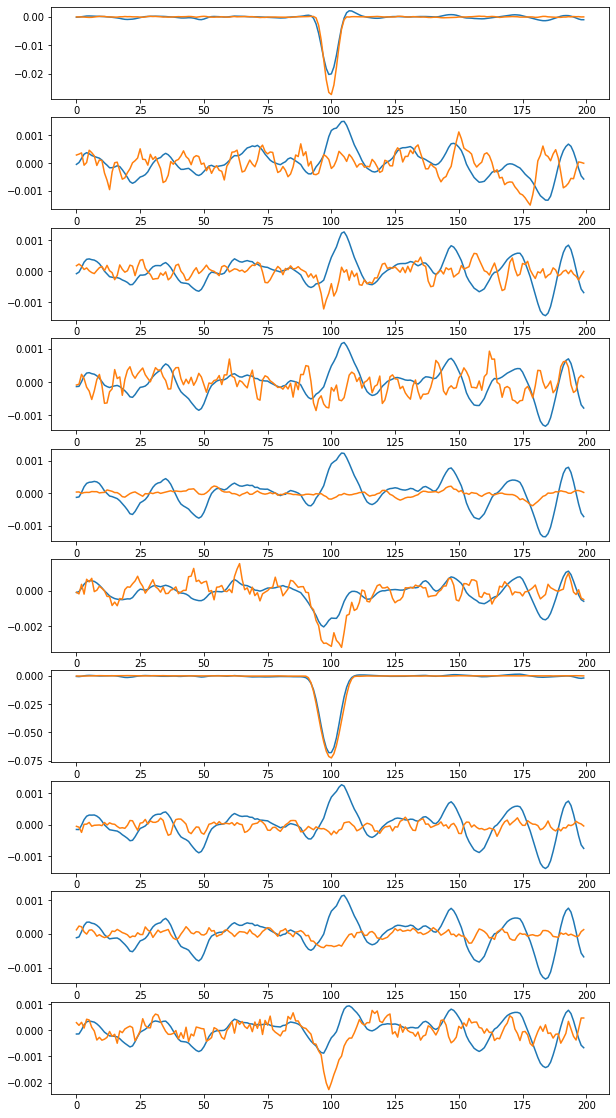

In [55]:
Ypred=rnn.predict(Xtest)
fig,ax=plt.subplots(10,1,figsize=(10,20))
inc=500
for i in range(10):
    ax[i].plot(Ypred[i+inc,:,0])
    ax[i].plot(Xtest[i+inc,:])

In [56]:
inp_ex = keras.layers.Input(shape=(3,), name="encoder_input")
x3 = keras.layers.concatenate([op, inp_ex],name='combine_layer')
x3 = keras.layers.Dense(16, activation='tanh',name='class_lay_1')(op)
x3 = keras.layers.Dense(8, activation='relu',name='class_lay_2')(x3)
x3 = keras.layers.Dense(1, activation='relu',name='class_lay_3')(x3)
class_out = keras.layers.Dense(2, activation='softmax',name='class_op_layer')(x3)

full_model=keras.models.Model([inp,inp_ex],class_out,name="classifier")

for layer in full_model.layers[0:6]:
    layer.trainable = False

full_model.summary()

full_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),metrics='accuracy')

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
rnn_input (InputLayer)          [(None, 200)]        0                                            
__________________________________________________________________________________________________
reshape_7 (Reshape)             (None, 200, 1)       0           rnn_input[0][0]                  
__________________________________________________________________________________________________
GRU_lay_1 (LSTM)                (None, 200, 20)      1760        reshape_7[0][0]                  
__________________________________________________________________________________________________
GRU_lay_2 (LSTM)                (None, 200, 40)      9760        GRU_lay_1[0][0]                  
_________________________________________________________________________________________

In [57]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
#history=vae.fit(Xtrain, Xtrain, epochs=20, batch_size=64 ,verbose=1, validation_split=0.3)
history=full_model.fit([Xtrain,Xextra_tr], Ytrain, epochs=70, batch_size=64 ,verbose=1,shuffle=True, validation_split=0.2)

Epoch 1/70
81/81 [==============================] - 17s 103ms/step - loss: 0.6935 - accuracy: 0.4902 - val_loss: 0.6932 - val_accuracy: 0.4934
Epoch 2/70
81/81 [==============================] - 8s 95ms/step - loss: 0.6934 - accuracy: 0.5051 - val_loss: 0.6931 - val_accuracy: 0.5066
Epoch 3/70
81/81 [==============================] - 7s 88ms/step - loss: 0.6935 - accuracy: 0.4962 - val_loss: 0.6931 - val_accuracy: 0.5066
Epoch 4/70
81/81 [==============================] - 7s 90ms/step - loss: 0.6935 - accuracy: 0.4912 - val_loss: 0.6931 - val_accuracy: 0.5066
Epoch 5/70
81/81 [==============================] - 7s 92ms/step - loss: 0.6933 - accuracy: 0.5003 - val_loss: 0.6935 - val_accuracy: 0.4934
Epoch 6/70
81/81 [==============================] - 8s 93ms/step - loss: 0.6933 - accuracy: 0.5032 - val_loss: 0.6931 - val_accuracy: 0.5066
Epoch 7/70
81/81 [==============================] - 6s 72ms/step - loss: 0.6933 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5066
Epoch 8/70


KeyboardInterrupt: 

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
#Xtest=np.array(Xtrain).reshape(1138, 7936, 1)
#Xtest=preprocessing.normalize(Xtest)
#Xtest=np.array(Xtest).reshape(358, 2000, 1)
test_loss, test_acc =  full_model.evaluate([np.array(Xtest),np.array(Xextra_tst)],np.array(Ytest))
print('Test accuracy:', test_acc)
Y_pred = full_model.predict([np.array(Xtest),Xextra_tst])
Ypred=np.argmax(Y_pred, axis=1)
Ytest_new=np.argmax(Ytest,axis=1)
cm = confusion_matrix(Ytest_new, Ypred)
print(cm)

23/23 [==============================] - 1s 46ms/step - loss: 0.5836 - accuracy: 0.6811
Test accuracy: 0.6810584664344788
[[262  80]
 [149 227]]
